In [ ]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from sklearn import metrics
import random
import sklearn
import matplotlib

In [ ]:
print(cv2.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(np.__version__)

4.4.0
3.2.2
1.0.2
1.19.5


In [ ]:
#specify data directory and results directory
data_dir = 'drive/MyDrive/DATA'
results_dir = 'drive/MyDrive/RESULTS'

In [ ]:
# mount your local drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#install openCV version that has SIFT enabled
!pip install opencv-contrib-python==4.4.0.44

# 1. Creating an SIFT based feature matcher

The feature matcher will be used to identify the cards most similar to a given card using keypoint matching.

In [ ]:
#read sample cropped card image (read from directory created in Tasl-1)
img_original = cv2.imread(os.path.join(results_dir, 'card_crops', 'train-001', '10.jpg'))
#convert from BGR to RGB space for display purposes
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

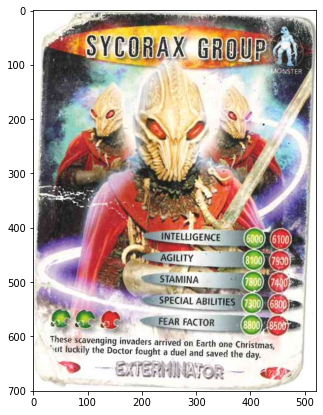

In [ ]:
#display card image
plt.figure(figsize=(7,7))
plt.imshow(img_original)
plt.show()

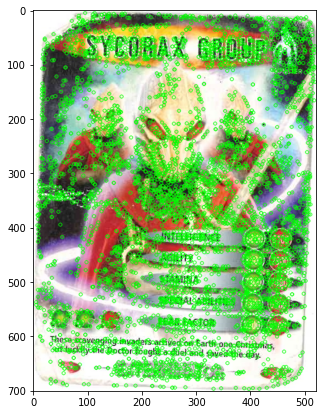

In [ ]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

kp = sift.detect(img_original,None)

t_img = img_original.copy()
img_with_keypoints = cv2.drawKeypoints(t_img, kp, outImage=np.array([]), color=(0, 255, 0))

fig = plt.figure(figsize=(7,7))
plt.imshow(img_with_keypoints)
plt.show()

### Read two card images to compare original with

`image_compare_1` is a different card altogether and should match with a low score against the original.
`image_compare_2` is another card with the same ID as the original and should match with a higher score.

In [ ]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# read images to compare with
img_compare_1 = cv2.imread(os.path.join(results_dir, 'card_crops', 'train-012', '14.jpg'))
img_compare_1 = cv2.cvtColor(img_compare_1, cv2.COLOR_BGR2RGB)

img_compare_2 = cv2.imread(os.path.join(results_dir, 'card_crops', 'train-012', '16.jpg'))
img_compare_2 = cv2.cvtColor(img_compare_2, cv2.COLOR_BGR2RGB)

### Find the keypoints and descriptors with SIFT

SIFT finds keypoints within each image. Every keypoint is associated with a `128` dimensional feature vector that describes the keypoint. If the descriptors of two keypoints are similar to each other, they can be said to match well.

A large number of such keypoint matches between any two images would suggest that the images themselves are similar to each other.

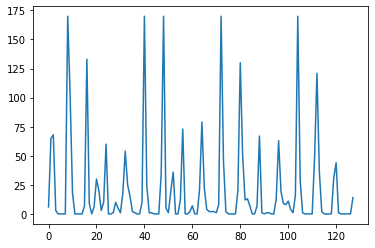

(5134, 128)


In [ ]:
#finding for original image
kp_original, des_original = sift.detectAndCompute(img_original,None)

#finding for images to compare against
kp_compare_1, des_compare_1 = sift.detectAndCompute(img_compare_1,None)
kp_compare_2, des_compare_2 = sift.detectAndCompute(img_compare_2,None)

# plot first keypoint descriptor of original image (for reference)
plt.plot(des_original[0,:])
plt.show()
print(des_original.shape)

# print(des_compare.shape)

# plt.plot(des_compare[0,:]) # plot first keypoint descriptor
# plt.show()

### Compute keypoint matches using KD-Trees

For each keypoint in the original image, the closest neighbour from the comparison image is computed.

In [ ]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 2)
search_params = dict(checks=50)   # or pass empty dictionary
#search_params = dict()

flann = cv2.FlannBasedMatcher(index_params,search_params) # make FLANN searcher
flann_matches_1 = flann.knnMatch(des_original,des_compare_1,k=2) # find matches!
flann_matches_2 = flann.knnMatch(des_original,des_compare_2,k=2)

## a. Comparison with DISSIMILAR image

The ratio test is used to pick out significant keypoints and remove some noise among the keypoints. The remaining matches are visualized for reference.

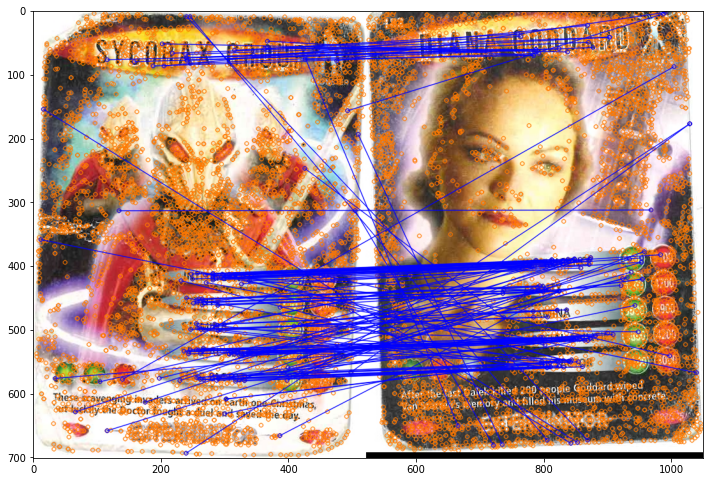

In [ ]:
matchesMask = [[0,0] for i in range(len(flann_matches_1))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(flann_matches_1):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,0,255),
                   singlePointColor = (255,120,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img5 = cv2.drawMatchesKnn(img_original,kp_original,img_compare_1,kp_compare_1,flann_matches_1,None,**draw_params)

plt.figure(figsize=(12,12))
plt.imshow(img5)
plt.show()

#### Computing the number of keypoint matches

The number of keypoint matches will be used as a metric to estimate how similar a given image is to another image. The higher the number, the better the match!

In [ ]:
match_count = 0
for ix,(m,n) in enumerate(flann_matches_1):
    if matchesMask[ix][0] == 1:
        match_count += 1

print('num keypoint matches: ', match_count)

num keypoint matches:  148


## b. Comparison with SIMILAR image

The ratio test is used to pick out significant keypoints and remove some noise among the keypoints. The remaining matches are visualized for reference.

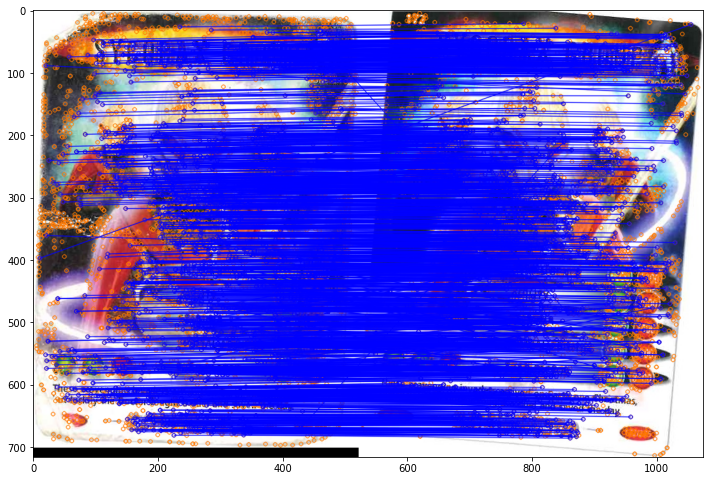

In [ ]:
matchesMask = [[0,0] for i in range(len(flann_matches_2))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(flann_matches_2):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,0,255),
                   singlePointColor = (255,120,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img5 = cv2.drawMatchesKnn(img_original,kp_original,img_compare_2,kp_compare_2,flann_matches_2,None,**draw_params)

plt.figure(figsize=(12,12))
plt.imshow(img5)
plt.show()

#### Computing the number of keypoint matches

The number of keypoint matches will be used as a metric to estimate how similar a given image is to another image. The higher the number, the better the match!

In [ ]:
match_count = 0
for ix,(m,n) in enumerate(flann_matches_1):
    if matchesMask[ix][0] == 1:
        match_count += 1

print('num keypoint matches: ', match_count)

num keypoint matches:  1492


### Comparison Results

It is clear from the above experiment that the number of keypoint matches for the similar case is much higher than that of the dissimilar case. Thus the SIFT feature matcher can be used to identify cards similar to a given card.

# 2. Finding similar matches for cards in `train-001`

The steps described above are employed to find the closest `M` matches for each card in `train-001`. A good predictor should return cards with the same ID as top matches followed by other matches.

In [ ]:
#creating list of directories containing comparison images (train-001) is excluded to avoid trivial matches
num_list = ['02','03','04','05','06','07','08','09','10','12','13','14']
scan_img_list = ['train-0{}'.format(x) for x in num_list]
scan_img_list

['train-002',
 'train-003',
 'train-004',
 'train-005',
 'train-006',
 'train-007',
 'train-008',
 'train-009',
 'train-010',
 'train-012',
 'train-013',
 'train-014']

### Initialize SIFT and define function to apply feature matching

In [ ]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 2)
search_params = dict(checks=50)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

def find_similar_cards(img, M):
    
    # find the keypoints and descriptors with SIFT
    kp_original, des_original = sift.detectAndCompute(img,None)
    
    match_images = []
    match_scores = []
    
    for p in scan_img_list:
        cur_dir = os.path.join(results_dir, 'card_crops',p)
        for f_name in os.listdir(cur_dir):
            if f_name.endswith('.jpg'):
                compare_image = cv2.imread(os.path.join(cur_dir, f_name))
                compare_image = cv2.cvtColor(compare_image, cv2.COLOR_BGR2RGB)

                kp_compare, des_compare = sift.detectAndCompute(compare_image,None)
                flann = cv2.FlannBasedMatcher(index_params,search_params) # make FLANN searcher
                flann_matches = flann.knnMatch(des_original,des_compare,k=2) # find matches!

                matchesMask = [[0,0] for i in range(len(flann_matches))]

                # ratio test as per Lowe's paper
                for i,(m,n) in enumerate(flann_matches):
                    if m.distance < 0.7*n.distance:
                        matchesMask[i]=[1,0]

                match_count = 0
                for ix,(m,n) in enumerate(flann_matches):
                    if matchesMask[ix][0] == 1:
                        match_count += 1

                match_images.append(compare_image)
                match_scores.append(match_count)
                zipped = zip(match_images, match_scores)

    sorted_matches = sorted(zipped, key=lambda x: x[1], reverse=True)
    #print('Best {} matches are: '.format(M))
    #print(sorted_matches[:M])
        
    return sorted_matches[:M]

### Find best matches

Loop through each image in `train-001` and find best matches for the same. 

WARNING: The matching process may take about 30 seconds per image in `train-001` and whole process should be completed in about 5 to 7 minutes.

In [ ]:
#dictionary to store best macthes for each image in 'train-001'
best_match_dict = {}
#dir with 'train-001' images
test_dir = os.path.join(results_dir, 'card_crops', 'train-001')

#number of top matches to retrieve
M = 5

#image limit because this takes a long time on colab
image_limit = 2

image_count = 0
for f_name in os.listdir(test_dir):
    if image_count == image_limit:
      break
    if f_name.endswith('.jpg'):
        print('Finding closest {} matches for {}'.format(M, os.path.join(test_dir, f_name)))
        test_image = cv2.imread(os.path.join(test_dir, f_name))
        test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
        
        best_matches = find_similar_cards(test_image, M)
        best_match_dict[f_name] = best_matches
        image_count += 1

Finding closest 5 matches for drive/MyDrive/RESULTS/card_crops/train-001/1.jpg
Finding closest 5 matches for drive/MyDrive/RESULTS/card_crops/train-001/2.jpg


### Display best matches

Below cell will display the best `M` matches for some random image in `train-001`. Cell can be run repeatedly to see results for different cards.

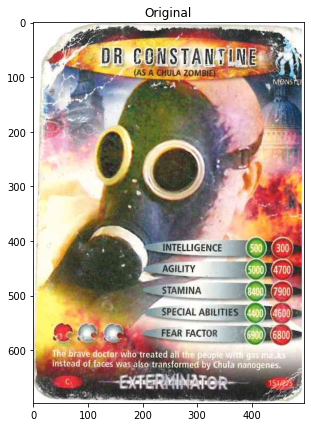

####################### Best Matches for 1.jpg ##########################


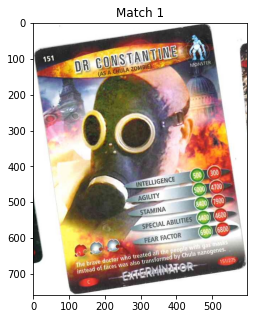

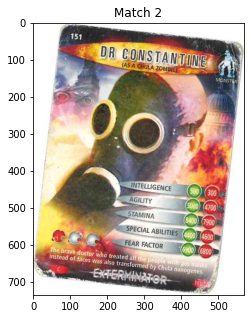

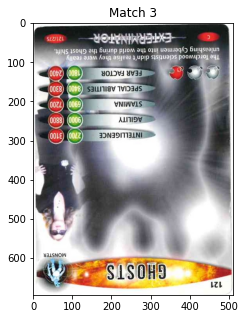

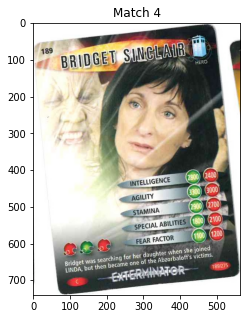

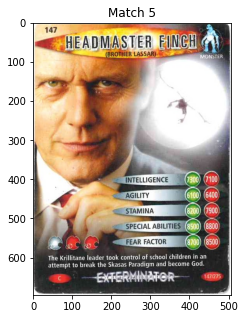

In [ ]:
show_image = random.choice(list(best_match_dict.keys()))

original = cv2.imread(os.path.join(test_dir, show_image))
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(7,7))
plt.imshow(original)
plt.title('Original')
plt.show()

print("####################### Best Matches for {} ##########################".format(show_image))
for j,(image, match_score) in enumerate(best_match_dict[show_image]):
    
    if j==M:
        break
        
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.title('Match {}'.format(j+1))
    plt.show()
    print('Match Score: ', match_score)